In [0]:
# Data download and unzipping for stage2
%%capture
!pip install kaggle
!mv kaggle.json .kaggle/
!kaggle competitions download -c data-science-bowl-2018 -f stage2_test_final.zip

!mkdir stage2_test_final
!unzip .kaggle/competitions/data-science-bowl-2018/stage2_test_final.zip -d stage2_test_final/

In [0]:
# Data download and unzipping for stage1
%%capture
!wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_test.zip -c
!wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_train.zip -c

!mkdir stage1_train stage1_test
!unzip stage1_train.zip -d stage1_train/
!unzip stage1_test.zip -d stage1_test/

In [3]:
from google.colab import files
uploaded = files.upload() # upload .py files

Saving data_utils.py to data_utils.py


In [0]:
import os
import random
import sys
import warnings
import numpy as np
import pandas as pd
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from keras.models import Model, load_model
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

# Setting seed for reproducability
SEED = 6
np.random.seed(SEED)
%matplotlib inline

In [0]:
from data_utils import read_train_data, read_test_data, rle_encoding, mask_to_rle
from model import get_unet, iou_metric, iou_metric_batch, my_iou_metric

In [7]:
# get train_data
X_train,Y_train = read_train_data()
# get test_data
test_img,test_img_sizes = read_test_data()

Getting and resizing train images and masks ... 
669/670 [============================>.] - ETA: 0s
Getting and resizing test images ... 
64/65 [============================>.] - ETA: 0s

In [0]:
#@title Hyperparameter { run: "auto", display-mode: "both" }
BATCH_SIZE = 32 #@param {type:"raw"}
EPOCHS = 50 #@param {type:"raw"}
LEARNING_RATE = 1e-3 #@param {type:"raw"}
OPTIMIZER = optimizers.Adam(lr=LEARNING_RATE) #@param {type:"raw"}
val_size = 0.25 #@param {type:"raw"}

In [9]:
# train/val split
train_img, val_img, train_mask, val_mask = train_test_split(X_train, Y_train, test_size=val_size, random_state=SEED)
train_size = len(train_img)
val_size = len(val_img)
print("train size", train_size)
print("val size", val_size)

train size 502
val size 168


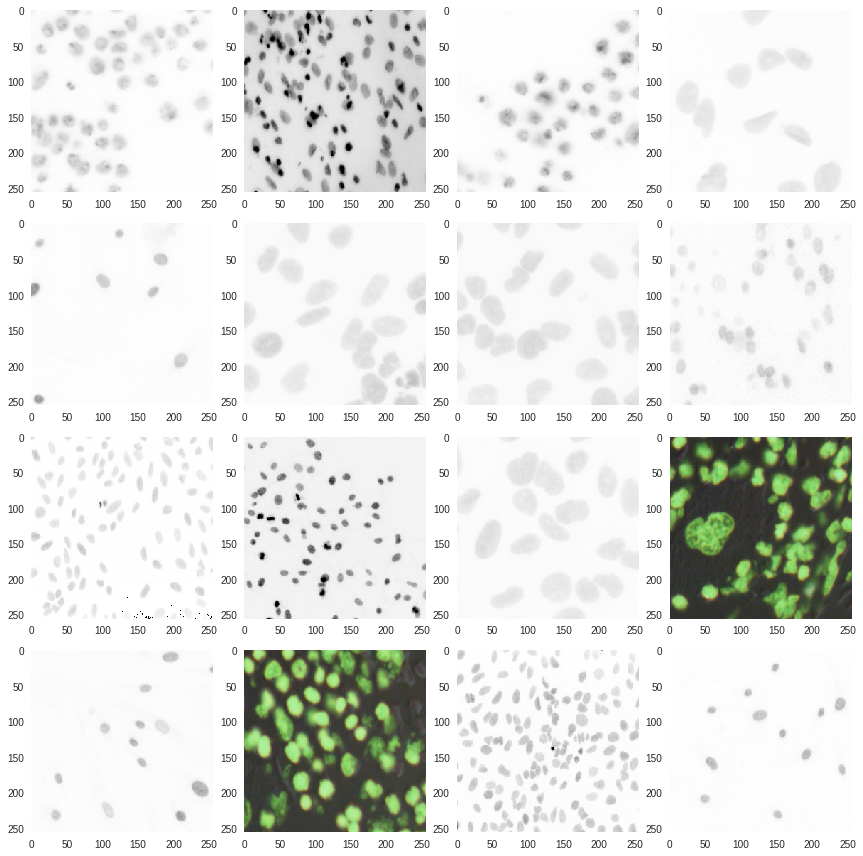

In [13]:
from keras.preprocessing.image import ImageDataGenerator
data_gen_args = dict(horizontal_flip=True,
                     vertical_flip=True,
                     # width_shift_range=0.1,
                     #height_shift_range=0.1,
                     fill_mode='reflect'
                     )

img_datagen = ImageDataGenerator(**data_gen_args)
img_datagen.fit(train_img, seed=SEED)
for X_batch in img_datagen.flow(train_img, batch_size=16, seed=SEED):
    fig, ax = plt.subplots(4, 4, figsize=(12, 12))
    row = 0
    col = 0
    for i in range(16):
        ax[row, col].grid(False)
        ax[row, col].imshow(X_batch[i])

        # Increment col index and reset each time
        # it gets to 4 to start a new row
        col = col + 1
        if(col == 4):
            col = 0

        # Increment row index every 4 items
        if((i + 1) % 4 == 0):
            row = row + 1
    plt.tight_layout()
    break

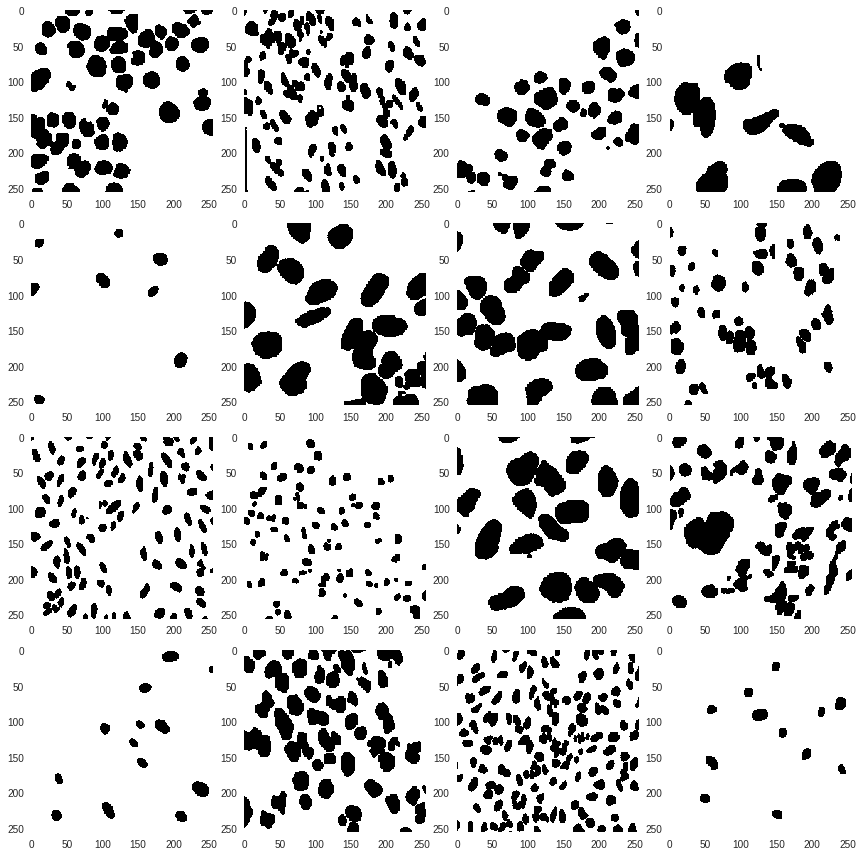

In [15]:
mask_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen.fit(train_mask, seed=SEED)

for Y_batch in mask_datagen.flow(train_mask, batch_size=16, seed=SEED):
    fig, ax = plt.subplots(4, 4, figsize=(12, 12))
    row = 0
    col = 0
    for i in range(16):
        ax[row, col].grid(False)
        ax[row, col].imshow( np.squeeze(Y_batch[i]))

        # Increment col index and reset each time
        # it gets to 4 to start a new row
        col = col + 1
        if(col == 4):
            col = 0

        # Increment row index every 4 items
        if((i + 1) % 4 == 0):
            row = row + 1
    plt.tight_layout()
    break

In [0]:
from keras.preprocessing.image import ImageDataGenerator
data_gen_args = dict(horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')
val_gen_args = dict()

In [0]:
img_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen.fit(train_mask, seed=SEED)
img_datagen.fit(train_img, seed=SEED)

x = img_datagen.flow(train_img, batch_size=BATCH_SIZE, seed=SEED)
y = mask_datagen.flow(train_mask, batch_size=BATCH_SIZE, seed=SEED)

train_generator = zip(x, y)

img_datagen_val = ImageDataGenerator(**val_gen_args)
mask_datagen_val = ImageDataGenerator(**val_gen_args)
img_datagen_val.fit(val_img, seed=SEED)
mask_datagen_val.fit(val_mask, seed=SEED)

x_val = img_datagen_val.flow(val_img, batch_size=BATCH_SIZE, seed=SEED)
y_val = img_datagen_val.flow(val_mask, batch_size=BATCH_SIZE, seed=SEED)

val_generator = zip(x_val, y_val)

In [0]:
u_net_aug = get_unet(OPTIMIZER=OPTIMIZER)

In [19]:
print("Training...\n")
filepath="best_aug_model.h5" # save best model only
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath, monitor='val_my_iou_metric', 
                               verbose=1, save_best_only=True, mode='max')
results_aug = u_net_aug.fit_generator(train_generator, steps_per_epoch=100,epochs=EPOCHS, 
                                      validation_data=val_generator, validation_steps=len(val_img)/(BATCH_SIZE),
                                      callbacks=[earlystopper, checkpointer])

Training...

Epoch 1/50
100/100 [==============================] - 83s 830ms/step - loss: 0.3250 - my_iou_metric: 0.0541 - val_loss: 0.1468 - val_my_iou_metric: 0.2877

Epoch 00001: val_my_iou_metric improved from -inf to 0.28773, saving model to best_aug_model.h5
Epoch 2/50
100/100 [==============================] - 73s 729ms/step - loss: 0.1266 - my_iou_metric: 0.3477 - val_loss: 0.0823 - val_my_iou_metric: 0.4424

Epoch 00002: val_my_iou_metric improved from 0.28773 to 0.44240, saving model to best_aug_model.h5
Epoch 3/50
 81/100 [=======================>......] - ETA: 13s - loss: 0.0950 - my_iou_metric: 0.4441100/100 [==============================] - 73s 731ms/step - loss: 0.0932 - my_iou_metric: 0.4487 - val_loss: 0.0709 - val_my_iou_metric: 0.4884

Epoch 00003: val_my_iou_metric improved from 0.44240 to 0.48838, saving model to best_aug_model.h5
Epoch 4/50
100/100 [==============================] - 73s 731ms/step - loss: 0.0840 - my_iou_metric: 0.4774 - val_loss: 0.0692 - val_my

### Train/val loss and train/val IoU

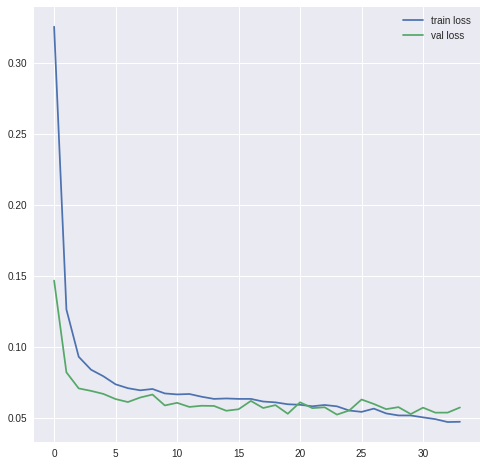

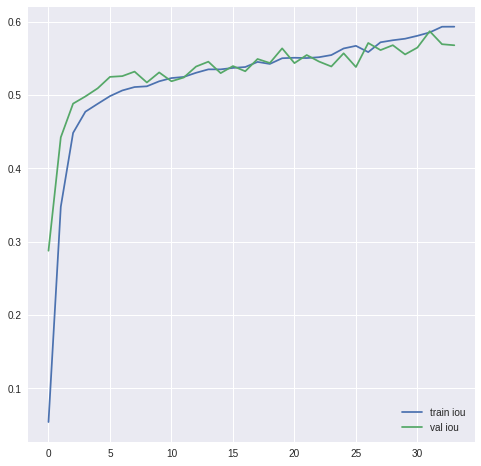

In [20]:
loss = results_aug.history['loss']
val_loss = results_aug.history['val_loss']
acc = results_aug.history['my_iou_metric']
val_acc = results_aug.history['val_my_iou_metric']
plt.figure(figsize=(8,8))
plt.plot(np.arange(len(loss)), np.array(loss), label='train loss')
plt.plot(np.arange(len(val_loss)), np.array(val_loss), label='val loss')
plt.legend(loc=1)

plt.figure(figsize=(8,8))
plt.plot(np.arange(len(acc)), np.array(acc), label='train iou')
plt.plot(np.arange(len(val_acc)), np.array(val_acc), label='val iou')
plt.legend(loc=4)

In [21]:
best_model = load_model('best_aug_model.h5', custom_objects={'my_iou_metric': my_iou_metric})
print('Predicting...')
train_pred = best_model.predict(train_img, verbose=1)
val_pred = best_model.predict(val_img, verbose=1)
test_pred = best_model.predict(test_img, verbose=1)
train_iou = iou_metric_batch(train_mask, train_pred)
val_iou = iou_metric_batch(val_mask, val_pred)
print('Best train IOU = ', train_iou)
print('Best val IOU = ', val_iou)

65/65 [==============================] - 1s 11ms/step
Best train IOU =  0.61044186
Best val IOU =  0.5704427


### Visualization of the prediction

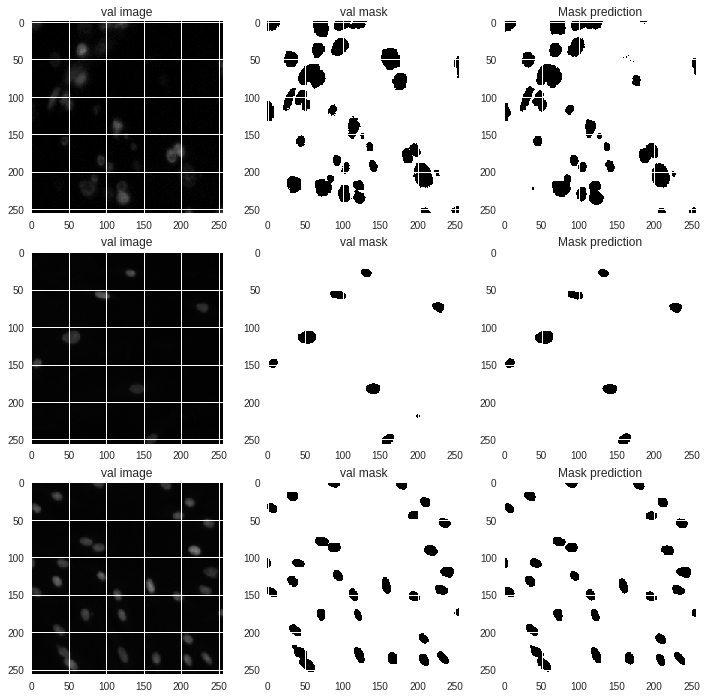

In [22]:
ids = np.random.choice(range(len(val_img)), 3, replace=False)
plt.figure(figsize=(12,12))
j = 0
for i in range(len(ids)):
    plt.subplot(331 + j)
    plt.imshow(val_img[ids[i]])
    plt.title("val image")
    plt.subplot(331 + j + 1)
    plt.imshow(np.squeeze(val_mask[ids[i]]))
    plt.title("val mask")
    plt.subplot(331 + j + 2)
    plt.imshow(np.squeeze(val_pred[ids[i]] > 0.5))
    plt.title("Mask prediction")
    j += 3
plt.show()

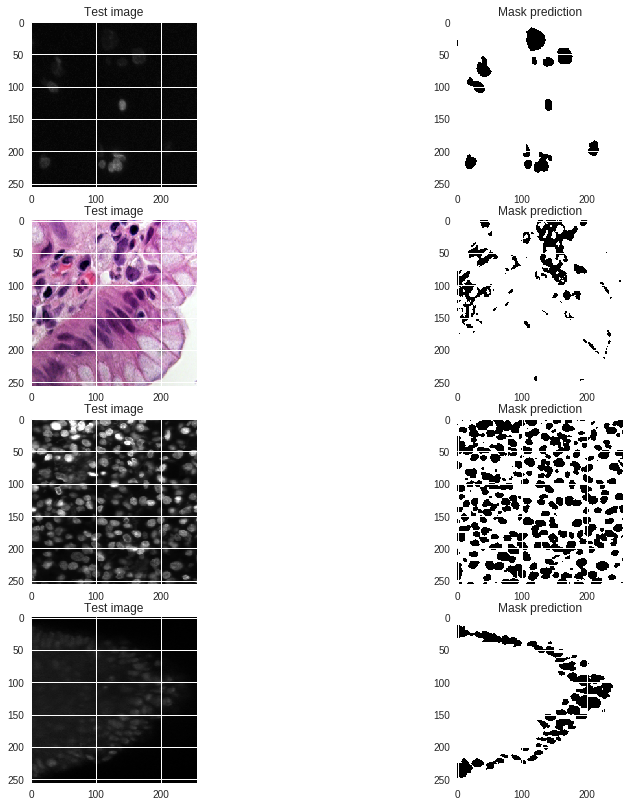

In [23]:
ids = np.random.choice(range(len(test_img)), 4, replace=False)
plt.figure(figsize=(14,14))
j = 0
for i in range(len(ids)):
    plt.subplot(421 + j)
    plt.imshow(test_img[ids[i]])
    plt.title("Test image")
    plt.subplot(421 + j + 1)
    j += 2
    plt.imshow(np.squeeze(test_pred[ids[i]] > 0.5))
    plt.title("Mask prediction")
plt.show()

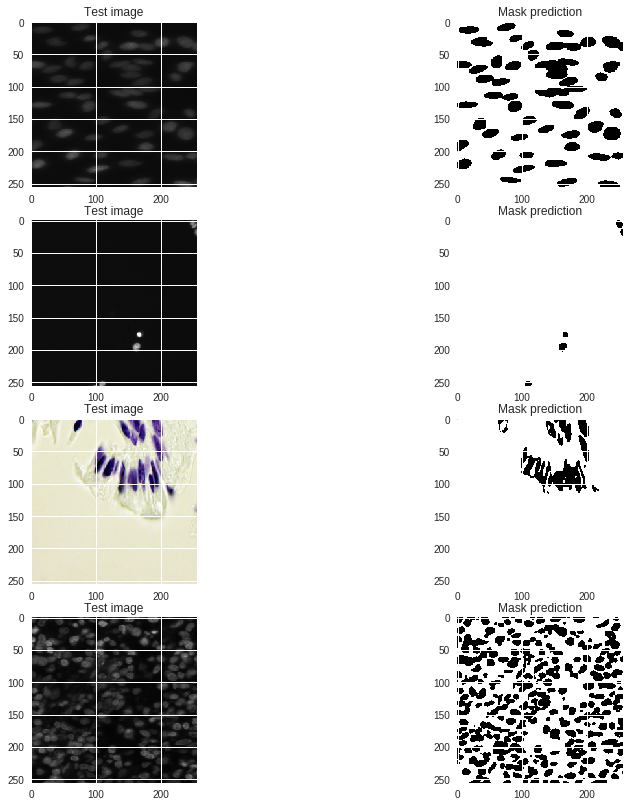

In [24]:
ids = np.random.choice(range(len(test_img)), 4, replace=False)
plt.figure(figsize=(14,14))
j = 0
for i in range(len(ids)):
    plt.subplot(421 + j)
    plt.imshow(test_img[ids[i]])
    plt.title("Test image")
    plt.subplot(421 + j + 1)
    j += 2
    plt.imshow(np.squeeze(test_pred[ids[i]] > 0.5))
    plt.title("Mask prediction")
plt.show()

In [0]:
# Create list of upsampled test masks
test_mask_upsampled = []
for i in range(len(test_pred)):
    test_mask_upsampled.append(resize(np.squeeze(test_pred[i]),
                                       (test_img_sizes[i][0],test_img_sizes[i][1]), 
                                       mode='constant', preserve_range=True))

In [0]:
test_ids,rles = mask_to_rle(test_mask_upsampled)

In [0]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))

sub.to_csv('sub_unet_aug.csv', index=False)

In [0]:
from google.colab import files
files.download('sub_unet_aug.csv')
files.download('best_aug_model.h5')